In [1]:
# System modules
import sys
from datetime import datetime
from IPython.display import display
from ipywidgets import Dropdown


# Data analysis modules
import pandas as pd
import numpy as np
from scipy.stats import uniform, norm, beta, weibull_min, rv_discrete
import random

# SimPy modules
import simpy
from simpy import Resource, Container, FilterStore
from simpy.util import start_delayed

# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import Map, FeatureGroup, Marker, LayerControl

# DESaster Modules
desaster_path = "./DESaster-master" # <-- Change this for your path
sys.path.append(desaster_path)
import desaster
from desaster.io import *
from desaster.structures import *
from desaster.financial import *
from desaster.technical import *
from desaster.entities import *
from desaster.policies import *
from desaster.visualize import dashboard, folium_map

In [2]:
scenario_file = './DESaster-master/inputs/desaster_input_data_template.xlsx'

In [3]:
owners_df = pd.read_excel(scenario_file, sheet_name='owners')

In [4]:
owners_df.columns

Index([u'name', u'address', u'occupancy', u'tenure', u'income', u'savings',
       u'credit', u'insurance', u'monthly_cost', u'move_in_cost', u'bedrooms',
       u'bathrooms', u'area', u'year_built', u'value', u'damage_state',
       u'listed', u'longitude', u'latitude', u'landlord', u'landlord_savings',
       u'landlord_insurance', u'landlord_credit'],
      dtype='object')

In [5]:
env = simpy.Environment()


In [6]:
write_story = True


In [7]:
fema_ia_dist = norm(loc = 10, scale = 0)
sba_home_sba_dist = norm(loc = 10, scale = 0)
sba_biz_sba_dist = norm(loc = 10, scale = 0)
insurance_dist = norm(loc = 10, scale = 0)
start_delay_dist = norm(loc = 10, scale = 0)
inspection_dist = norm(loc = 0.5, scale = 0)
assessment_dist = norm(loc = 10, scale = 0)
permitting_dist = norm(loc = 10, scale = 0)
repair_dist = norm(loc = 10, scale = 0)
demolition_dist = norm(loc = 10, scale = 0)
occupy_dist = norm(loc = 10, scale = 0)
find_home_dist = norm(loc = 10, scale = 0)

declaration = norm.rvs(loc = 30, scale = 0) # Placeholder deterministic scalar that defines number of days before federal disaster declared
sba_deadline = norm.rvs(loc = 60, scale = 0) # Typically duration in days after declaration that SBA applications must be submitted

In [8]:
# Instantiate a FEMA Individual Assistance program
fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration=fema_ia_dist, 
                                max_outlay=30000, deadline=540, declaration=declaration)

# Instantiate a SBA Loan program to use w/ OwnerHouseholds
sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_home_sba_dist, 
                                max_loan = 200000, min_credit = 600, deadline=sba_deadline,
                                declaration=declaration)

# Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_biz_sba_dist, 
                           max_loan = 2000000, deadline=sba_deadline, declaration=declaration) # SBA max biz loan = $2mil

# Instantiate a private insurance program
insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration=insurance_dist)

# Instantiate a rapid inspeaction (tagging) program
inspection = InspectionProgram(env, staff=1000, duration=inspection_dist)

# Instantiate a detailed engineering assessment program
assessment = EngineeringAssessment(env, staff=1000, duration=assessment_dist)

# Instantiate a building permit processing program
permitting = PermitProgram(env, staff=1000, duration=permitting_dist) 

# Instantiate a program to represent private repair contractors
repair = RepairProgram(env, staff=1000, materials=1000000000, duration=repair_dist)

# Instantiate a program to represent private demolition contractors
demolition = DemolitionProgram(env, staff=1000, duration=demolition_dist)

In [9]:
# Apply for insurance, FEMA IA, and SBA in that seqence
insurance_ia_sba_seq = Insurance_IA_SBA_Sequential(env)

# Apply for insurance, FEMA IA, and SBA in at the same time
insurance_ia_sba_para = Insurance_IA_SBA_Parallel(env)

# Apply for insurance first, then apply to FEMA IA and SBA at the same time
insurance_firstthen_ia_sba_para = Insurance_FirstThen_IA_SBA_Parallel(env)

# Apply for insurance and SBA in that seqence
insurance_sba_seq = Insurance_SBA_Sequential(env)

# Apply for insurance and SBA at the same time
insurance_sba_para = Insurance_SBA_Parallel(env)

# A policy to simulate government buyout to repair homes 
repair_stock = RepairVacantBuilding(env)

In [10]:
owned_stock = FilterStore(env)  # To put the residences associated with owners

forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords

In [11]:
owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)


In [12]:
def basic_process(inspection_program, assessment_program, permit_program, repair_program, entity):
        
    yield env.process(inspection_program.process(entity.property, entity))
    
    yield env.process(assessment_program.process(entity.property, entity))
    
    yield env.process(permit_program.process(entity.property, entity))
    
    yield env.process(repair_program.process(entity.property, entity))

In [13]:
def owner_process(env, inspection_program, insurance_program, fema_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, 
                  search_stock, entity):
    
    money_patience = 200000  # days until give up the search for rebuild money
    home_patience = 15000  # days until give up the search for a new home
    
    # Do inspections after inspectors are mobilized
    yield env.timeout(start_delay_dist.rvs())
    yield env.process(inspection_program.process(entity.property, entity))
    
    # Process damaged properties
    if entity.property.damage_state == 'None':
        yield env.process(entity.occupy(duration = occupy_dist)) # For book keeping; ~unrealistic 
    else:
        
        # Homeowner search for financial assistance. Note two alternate versions 
        # can be used: insurance_ia_sba_para, insurance_ia_sba_seq, and insurance_firstthen_ia_sba_para. 
        # Paste in the desired policy approach below.
        yield env.process(insurance_firstthen_ia_sba_para.policy(insurance_program, fema_program,
                                                   loan_program, entity, money_patience))

        # If not enough money to repair home or home completely damaged, search for a new home 
        # to purchase.
        if (entity.recovery_funds.level < entity.property.damage_value or
                entity.property.damage_state == 'Complete'):

            yield env.process(entity.find_home(search_stock, find_home_dist, down_payment_pct = 0.10,
                                                  search_patience = home_patience))
            
            if entity.gave_up_home_search == None:
                yield env.process(entity.occupy(duration = occupy_dist))
            
            return
        # Otherwise repair home.       
        elif entity.recovery_funds.level >= entity.property.damage_value:
            
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))    
            yield env.process(entity.occupy(duration = occupy_dist))

In [14]:
#inspect.getfullargspec(owner_process).args # Useful to determine what arguments are required for the process.

for i in range(len(owners)):
    env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i]))

In [15]:
env.run()


In [16]:
output_summary(owners, 'OwnerHousehold')


('8 out of 8 owners suffered damage to their homes.\n', '1 out of 8 owners rebuilt or repaired their damaged home.\n', '0 out of 8 owners gave up searching for money.\n', '0 out of 8 owners searchesd for a new home.\n', '0 out of 8 owners bought a new home.\n', '0 out of 8 owners gave up searching for a home.')


In [17]:
df = households_to_df(owners)


Household Ivy had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Edward had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Oswald had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household James had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Butch had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Harvey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Lee had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Carmine had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'


In [18]:
df.columns


Index([u'address', u'area', u'assessment', u'assessment_get',
       u'assessment_put', u'assistance_payout', u'bathrooms', u'bedrooms',
       u'claim_amount', u'claim_get', u'claim_put', u'credit', u'damage_state',
       u'damage_state_start', u'damage_value', u'damage_value_start',
       u'demolition_get', u'demolition_put', u'env', u'fema_amount',
       u'fema_get', u'fema_put', u'gave_up_funding_search',
       u'gave_up_home_search', u'home_get', u'home_put', u'income',
       u'inspected', u'inspection_get', u'inspection_put', u'insurance',
       u'latitude', u'listed', u'longitude', u'monthly_cost', u'name',
       u'occupancy', u'occupy_get', u'occupy_put', u'owner', u'permit',
       u'permit_get', u'permit_put', u'prior_properties', u'prior_residences',
       u'property', u'recovery_funds', u'recovery_limit_state',
       u'recovery_limit_state_start', u'repair_get', u'repair_put',
       u'residence', u'savings', u'sba_amount', u'sba_get', u'sba_put',
       u'stock', 

In [19]:
event_list=[]

for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
        event_list.append(i)

event_df = df[event_list]
event_df = event_df.set_index('name')

In [20]:
event_df


,assessment_get,assessment_put,claim_get,claim_put,damage_state_start,damage_value_start,demolition_get,demolition_put,fema_get,fema_put,...,inspection_put,occupy_get,occupy_put,permit_get,permit_put,recovery_limit_state_start,repair_get,repair_put,sba_get,sba_put
name,,,,,,,,,,,,,,,,,,,,,
Ivy,50,40,None,None,Moderate,27900.0,None,None,40,30,...,10.0,80.0,70.0,60,50,Disfunctional,70,60,None,30
Edward,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
Oswald,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
James,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
Butch,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
Harvey,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
Lee,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None
Carmine,None,None,None,None,None,0.0,None,None,None,None,...,10.0,20.5,10.5,None,None,Functional,None,None,None,None


In [26]:
names = sorted([f for f in df['name']])

name_chooser = Dropdown(
    options=names
)
display(name_chooser)

[<matplotlib.text.Text at 0x12049cc10>, <matplotlib.text.Text at 0x11c84a490>]

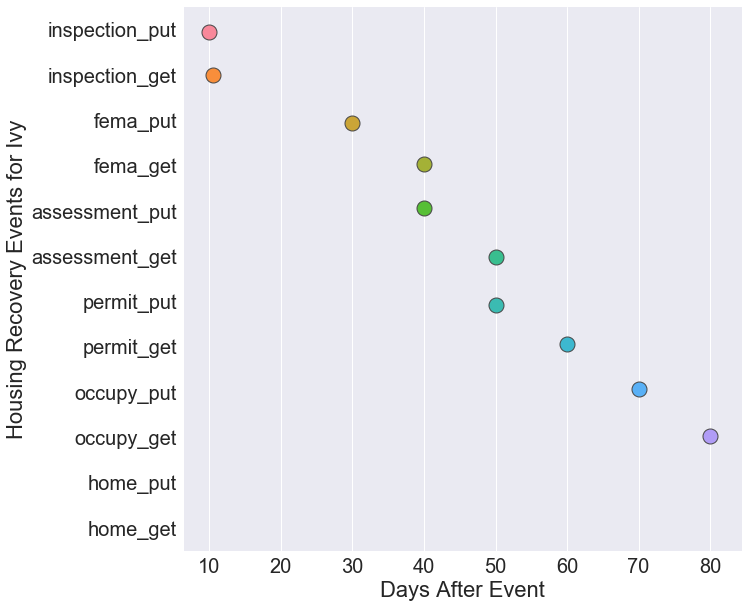

In [28]:
name = name_chooser.value

name_row = df[df['name']==name][['inspection_put',
 'inspection_get',
 'fema_put',
 'fema_get',
 'assessment_put',
 'assessment_get',
 'permit_put',
 'permit_get',
'occupy_put',
'occupy_get',
 'home_put',
 'home_get']]

%matplotlib inline
plt.figure(figsize=(10,10))
sns.set_style(style="whitegrid")
sns.set(font_scale=2)
ax = sns.stripplot(name_row.iloc[0], name_row.columns, jitter=True, size = 15, linewidth=1)
ax.set(xlabel="Days After Event", ylabel="Housing Recovery Events for {0}".format(name))